In [2]:
import pandas as pd
import numpy as np
import json
# Place Yelp dataset in ../yelp-dataset
yelp_dataset_path = '../yelp-dataset/'
print(yelp_dataset_path + 'yelp_academic_dataset_business.json')

data = [json.loads(line) for line in 
        open(yelp_dataset_path+'yelp_academic_dataset_business.json', 'r', encoding="utf8")]

../yelp-dataset/yelp_academic_dataset_business.json


In [3]:
data = [x for x in data if x['city']=='Toronto']
data = np.array(data) # Convert list to numpy array

In [4]:
#len(tor_total_business)

In [5]:
#ok = np.array(tor_total_business)

In [6]:
# test = []
# for i in range(len(tor_total_business)):
#     test.append(tor_total_business[i]['user_id'])
# test = np.array(test)

In [7]:
# unique, counts = np.unique(test, return_counts=True)
# ok =dict(zip(unique, counts))
# final_l = []
# recs=0
# for i in range(len(counts)):
#     if counts[i]>=15:
#         final_l.append(unique[i])
#         recs += counts[i]

In [8]:
# final_l = np.array(final_l)

In [9]:
# with open(yelp_dataset_path + 'yelp_academic_dataset_review.json') as myfile:
#     head = [next(myfile) for x in range(1)]
# print(head)

# Βημα 2

In [133]:
import pandas as pd 
import math
import numpy as np
import json

table_R = pd.read_csv("pruned_data.csv", header = None)
new_header = ['user_id', 'business_id', 'rating']
table_R.columns = new_header[:]
print(table_R)

                       user_id             business_id  rating
0       TZQSUDDcA4ek5gBd6BzcjA  qUWqjjjfpB2-4P3He5rsKw     4.0
1       TZQSUDDcA4ek5gBd6BzcjA  6n_MDeYxU1ihB38be9TkVA     4.0
2       TZQSUDDcA4ek5gBd6BzcjA  jo4KmAqlZ7vxjHIP7IIkAw     5.0
3       TZQSUDDcA4ek5gBd6BzcjA  dsAcgF6qtZy2m6d_yWCrGQ     4.0
4       TZQSUDDcA4ek5gBd6BzcjA  siaRCT2-PkyeXUVKrywcTg     4.0
...                        ...                     ...     ...
197107  3L3CI2Om_2SE3T6hxrJKPQ  j_hB9Gt3VMJAbA2JyvyFjw     4.0
197108  3L3CI2Om_2SE3T6hxrJKPQ  WKcVegcUjAld1S737a_QHw     4.0
197109  3L3CI2Om_2SE3T6hxrJKPQ  1FL3oE2mqq_EFAYPd1TWUg     5.0
197110  3L3CI2Om_2SE3T6hxrJKPQ  hlrZHM4D48XiQtXh6cRg_w     1.0
197111  3L3CI2Om_2SE3T6hxrJKPQ  _cVCzKQGt23KKW1M07Yvkw     5.0

[197112 rows x 3 columns]


In [134]:
print("Sample data should have {} rows \n".format(math.ceil(len(table_R)*0.05)))
sample_data = table_R.sample(frac=0.05)
print(len(sample_data))

Sample data should have 9856 rows 

9856


In [135]:
print(sample_data.index) # sampled indexes

# Setting sample ratings to Nan
for index in sample_data.index:
    table_R['rating'].iloc[index] = np.nan

Int64Index([ 62823, 115947,  84685, 128167, 105212,  72693, 172886,  47471,
             96374,  68604,
            ...
            168110,  56426,  55304, 193431,   7037,  65812, 182503,  46453,
            166801, 163743],
           dtype='int64', length=9856)


/home/left/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [136]:
tableR = table_R.to_numpy()
unique_users, countsU = np.unique(tableR[:,0], return_counts=True)
unique_business, countsB = np.unique(tableR[:,1], return_counts=True)

In [137]:
sparse_array = np.zeros((len(unique_users), len(unique_business)))
# Create the sparse_array
for i in range(len(unique_users)):
    business_index = np.where( unique_users[i] == table_R['user_id'])
    
    for j in range(len(business_index[0])):
        temp_business = table_R['business_id'][business_index[0][j]] #take business_id for given index
        unique_business_ind = np.where(temp_business == unique_business)
        sparse_array[i][unique_business_ind[0][0]] = table_R['rating'][business_index[0][j]]

# Βημα 3

### Get user similarities table

In [138]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
spars = np.nan_to_num(sparse_array) # Change nan values from sparse_array to zero
similarities = cosine_similarity(spars)
sample_array = sample_data.to_numpy()

### This is helping functions to get user_id or business_id index in unique_users/business array

In [139]:
def find_index(user_id):
    ind = np.where(user_id  == unique_users)
    return ind[0][0]
def find_business(business_id):
    ind = np.where(business_id == unique_business)
    return ind[0][0]

### UCF prediction function

In [140]:
def UCF_prediction(user1, common_users, ratings):
    k_values = [1,5,10,20,50,100,200,500,1000]
    user_ind1 = find_index(user1)
    similar = []
    predictions_k = []
    # For every common user find his similarity to our user
    for i in range(len(common_users)):
        temp_ind = find_index(common_users[i])
        similar.append([common_users[i], float(similarities[user_ind1][temp_ind]), int(ratings[i])])
    
    # Sort similarities and take k most similar to our user
    from operator import itemgetter
    vectors = np.array(sorted(similar, key=itemgetter(1), reverse=True))
    
    # For every given k calculate the predictions for the given user
    for k in range(len(k_values)):
        temp_vectors = vectors[:k_values[k]]
        
        similarity_vector = temp_vectors[:,1].astype(float)
        ratings_vector = temp_vectors[:,2].astype(int)

        # Calculate prediction
        numerator = 0
        denominator = np.sum(similarity_vector)
        for i in range(len(similarity_vector)):
            numerator += similarity_vector[i]*ratings_vector[i]
        predictions_k.append(numerator/denominator)
        
    # Return a list with predictions for the user for every k value
    return predictions_k

### Prepare the data and execute UCF_prediction for every given k

In [141]:
predictions = []
business_avg_pred = []
for i in range(sample_array.shape[0]): # For every pair (u,b) that have missing rating
    common_users = []
    common_ratings = []
    business_index = find_business(sample_array[i][1]) # Get business index
    common_users_indexes = np.nonzero(spars[:,business_index]) # FIND INDEXES FOR NONZERO VALUES ONLY!
    for j in range(len(common_users_indexes[0])): # For every row in spars- (Actually for every user)
        common_ratings.append(spars[common_users_indexes[0][j]][business_index]) # Append ratings
        common_users.append(unique_users[common_users_indexes[0][j]]) # Append the user_id
    
    # Append the prediction
    predictions.append(UCF_prediction(sample_array[i][0], common_users, common_ratings))
    business_avg_pred.append(sum(common_ratings)/len(common_ratings))
    
ucf_predictions = np.array(predictions)

# Βημα 4

In [142]:
# Get transposed sparse array and similiarities between businesses
transposed_sparse = np.transpose(spars)
transposed_sparse.shape
business_similarities = cosine_similarity(transposed_sparse)

In [143]:
def ICF_prediction(business1, common_businesses, ratings):
    k_values = [1,5,10,20,40,50,60,70,80,100]
    business_ind1 = find_business(business1)
    similar = []
    predictions_k = []
    
    # For every common business find its' similarity to our business
    for i in range(len(common_businesses)):
        temp_ind = find_business(common_businesses[i])
        similar.append([common_businesses[i], float(business_similarities[business_ind1][temp_ind]), int(ratings[i])])
    
    # Sort similarities and take k most similar to our business
    from operator import itemgetter
    vectors = np.array(sorted(similar, key=itemgetter(1), reverse=True))
    
    # For every given k calculate the predictions for the given user
    for k in range(len(k_values)):
        temp_vectors = vectors[:k_values[k]]
        
        similarity_vector = temp_vectors[:,1].astype(float)
        ratings_vector = temp_vectors[:,2].astype(int)

        # Calculate prediction
        numerator = 0
        denominator = np.sum(similarity_vector)
        for i in range(len(similarity_vector)):
            numerator += similarity_vector[i]*ratings_vector[i]
        predictions_k.append(numerator/denominator)
        
    # Return a list with predictions for the user for every k value
    return predictions_k

### Prepare the data and execute ICF_prediction for every given k

In [144]:
predictions = []
user_avg_pred = []
for i in range(sample_array.shape[0]): # For every pair (u,b) that have missing rating
    common_ratings = []
    common_businesses = []
    user_index = find_index(sample_array[i][0]) # Get user index
    common_business_indexes = np.nonzero(spars[user_index,:]) # FIND BUSINESSES INDEXES FOR NONZERO VALUES ONLY!

    for j in range(len(common_business_indexes[0])): # For every row in spars- (Actually for every rated business)
        common_ratings.append(transposed_sparse[common_business_indexes[0][j]][user_index]) # Append ratings
        common_businesses.append(unique_business[common_business_indexes[0][j]]) # Append the user_id
    # Append the prediction
    predictions.append(ICF_prediction(sample_array[i][1], common_businesses, common_ratings))

    user_avg_pred.append(sum(common_ratings)/len(common_ratings))
    
ifc_predictions = np.array(predictions)

# Βήμα 5

In [145]:
from numpy.linalg import svd 
# array = np.array([  
#     1, 1, 1, 0, 0,
#     3, 3, 3, 0, 0,
#     4, 4, 4, 0, 0,
#     5, 5, 5, 0, 0,
#     0, 2, 0, 4, 4,
#     0, 0, 0, 5, 5,
#     0, 1, 0, 2, 2 ])
# array = array.reshape(7,5)


u, s, vt = svd(spars, full_matrices=False)
s = np.diag(s)

# keep the r largest singular vectors
r = 5
Rk_aprrox = u[:,:r] @ s[0:r, :r] @ vt[:r,:]

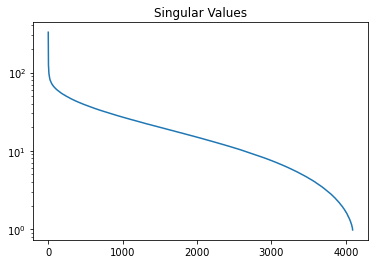

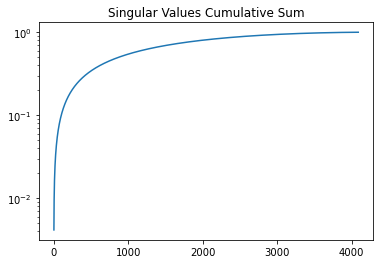

[[-0.00658068  0.00382912  0.03509852 ...  0.05879006  0.00251447
   0.05218558]
 [ 0.09141614  0.06584976  0.13591382 ...  0.29286908  0.14948718
   0.56270591]
 [ 0.01072979 -0.00202077  0.0165089  ...  0.01109215 -0.01326455
   0.03874703]
 ...
 [ 0.00974617  0.01222294  0.01673218 ...  0.04704957  0.02558296
   0.0512121 ]
 [ 0.01775879  0.00276552  0.00742858 ...  0.00757919 -0.00553701
   0.00929535]
 [ 0.02629357  0.00607778 -0.00627578 ... -0.00652032 -0.00190243
  -0.02845672]]


In [146]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.semilogy(np.diag(s))
plt.title('Singular Values')
plt.show()

plt.figure(2)
plt.semilogy(np.cumsum(np.diag(s)/np.sum(np.diag(s))))
plt.title('Singular Values Cumulative Sum')
plt.show()

print(Rk_aprrox)

# Βήμα 6

In [147]:
RMSE_UCF = []
true_ratings = sample_data['rating'].to_numpy()

for i in range(ucf_predictions[0].size):
    predicted_ratings = np.array(ucf_predictions[:,i])
    sum_of_difference = 0
    for i in range(sample_data.shape[0]):
        sum_of_difference += (predicted_ratings[i] - true_ratings[i])**2
    RMSE_UCF.append(math.sqrt(sum_of_difference/sample_data.shape[0]))

In [148]:
RMSE_ICF = []
true_ratings = sample_data['rating'].to_numpy()

for i in range(ifc_predictions[0].size):
    predicted_ratings = np.array(ifc_predictions[:,i])
    sum_of_difference = 0
    for i in range(sample_data.shape[0]):
        sum_of_difference += (predicted_ratings[i] - true_ratings[i])**2
    RMSE_ICF.append(math.sqrt(sum_of_difference/sample_data.shape[0]))

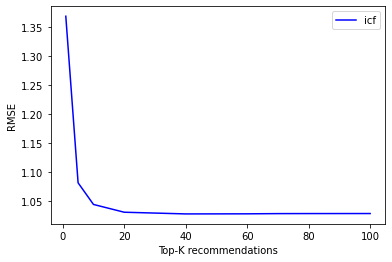

In [149]:
import matplotlib.pyplot as plt
x = [1,5,10,20,40,50,60,70,80,100]
#plt.plot(x, RMSE_UCF, "r", label = "ucf")
plt.plot(x, RMSE_ICF, "b", label = "icf")
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("Top-K recommendations");

In [150]:
RMSE_UCF

[1.320803204075499,
 1.0537261715949808,
 1.018550216891449,
 1.004048126011567,
 0.9996709791264708,
 0.9993192243319462,
 0.9992648102571303,
 0.9992776054030587,
 0.9992774282083636]

In [151]:
RMSE_ICF

[1.3685281576137986,
 1.0818455424587952,
 1.044616450224918,
 1.0312219856431832,
 1.028308127871317,
 1.028379555056531,
 1.0284684323832467,
 1.0288330147729416,
 1.0289033962262806,
 1.0289639929515544]